## 언어모델을 이용한 문장 생성

### 문장생성 구현

In [3]:
import sys
sys.path.append('deep2')
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

In [4]:
class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None,sample_size=100):
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1,1)
            score = self.predict(x)
            p = softmax(score.flatten())
            
            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
        return word_ids

In [9]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('Rnnlm.pkl')

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N','<unk>','$']
skip_ids = [word_to_id[word] for word in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace('<eos>','.\n')
print(txt)

you failed as the minimum wage only to curb structure on any neighborhood and weapon behind news equipment said .
 after a homeless he is not considering the ultimate act but it would keep profit hurt by eating for still and sells up by from an offerings .
 the machinists insist that cuts from recently follow to customers in april .
 but manufacturers are general vice presidents are somewhat anticipated .
 northrop corp. stern lake bell said the office will be reached but that it succeeded do n't provide productivity previously said payment will provide selected condition and proposing the


### 더 좋은 문장으로

## seq2seq
- encoder , decoder가 연결된 모델 (ex 번역기)


### 가변길이 시계열 데이터
- 덧셈 문제 같은 (54 + 31 =)

In [12]:
from dataset import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

### 구현

### encoder class

In [13]:
from common.time_layers import *

In [37]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D)/100).astype('f')
        lstm_Wx = (rn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx,lstm_Wh,lstm_b,stateful=False)
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None
        
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:,-1,:]
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:,-1,:] = dh 
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### decoder class

In [35]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D)/100).astype('f')
        lstm_Wx = (rn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W  = (rn(H,V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = True)
        self.affine = TimeAffine(affine_W, affine_b)
        self.params, self.grads = [],[]
        for layer in [self.embed, self.lstm, self.affine]:
            self.params += layer.params
            self.grads += layer.grads
        
    def forward(self, xs, h):
        self.lstm.set_state(h)
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1,1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
        return sampled

### Seq2seq 클래스 구현

In [41]:
from common.base_model import BaseModel

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
        
    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:,:-1], ts[:,1:]
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout
    
    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

 ### 평가

In [21]:
import matplotlib.pyplot as plt
%matplotlib notebook

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 4[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 5[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 5[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 6[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 7[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 8[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 8[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 9[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 10[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 11[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 11[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 12[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26

| 에폭 8 |  반복 341 / 351 | 시간 13[s] | 손실 1.05
Q 77+85  
T 162 
X 166 
---
Q 975+164
T 1139
X 1160
---
Q 582+84 
T 666 
X 668 
---
Q 8+155  
T 163 
X 173 
---
Q 367+55 
T 422 
X 438 
---
Q 600+257
T 857 
X 873 
---
Q 761+292
T 1053
X 1073
---
Q 830+597
T 1427
X 1449
---
Q 26+838 
T 864 
X 868 
---
Q 143+93 
T 236 
X 253 
---
검증 정확도 2.880%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 1.05
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 1.02
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 1.00
| 에폭 9 |  반복 61 / 351 | 시간 2[s] | 손실 0.99
| 에폭 9 |  반복 81 / 351 | 시간 3[s] | 손실 0.99
| 에폭 9 |  반복 101 / 351 | 시간 3[s] | 손실 0.99
| 에폭 9 |  반복 121 / 351 | 시간 4[s] | 손실 0.99
| 에폭 9 |  반복 141 / 351 | 시간 5[s] | 손실 0.99
| 에폭 9 |  반복 161 / 351 | 시간 6[s] | 손실 1.01
| 에폭 9 |  반복 181 / 351 | 시간 6[s] | 손실 0.99
| 에폭 9 |  반복 201 / 351 | 시간 7[s] | 손실 0.98
| 에폭 9 |  반복 221 / 351 | 시간 8[s] | 손실 0.98
| 에폭 9 |  반복 241 / 351 | 시간 9[s] | 손실 0.99
| 에폭 9 |  반복 261 / 351 | 시간 9[s] | 손실 0.99
| 에폭 9 |  반복 281 / 351 | 시간 10[s] | 손실 0.98
| 에폭 9 |  반복 301 / 351

| 에폭 16 |  반복 141 / 351 | 시간 5[s] | 손실 0.87
| 에폭 16 |  반복 161 / 351 | 시간 6[s] | 손실 0.88
| 에폭 16 |  반복 181 / 351 | 시간 6[s] | 손실 0.87
| 에폭 16 |  반복 201 / 351 | 시간 7[s] | 손실 0.84
| 에폭 16 |  반복 221 / 351 | 시간 8[s] | 손실 0.85
| 에폭 16 |  반복 241 / 351 | 시간 9[s] | 손실 0.91
| 에폭 16 |  반복 261 / 351 | 시간 9[s] | 손실 0.88
| 에폭 16 |  반복 281 / 351 | 시간 10[s] | 손실 0.89
| 에폭 16 |  반복 301 / 351 | 시간 11[s] | 손실 0.86
| 에폭 16 |  반복 321 / 351 | 시간 12[s] | 손실 0.83
| 에폭 16 |  반복 341 / 351 | 시간 12[s] | 손실 0.85
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1129
---
Q 582+84 
T 666 
X 667 
---
Q 8+155  
T 163 
X 158 
---
Q 367+55 
T 422 
X 419 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1049
---
Q 830+597
T 1427
X 1418
---
Q 26+838 
T 864 
X 862 
---
Q 143+93 
T 236 
X 235 
---
검증 정확도 8.200%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.83
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.84
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.86
| 에폭 17 |  반복 61 / 351 | 시간 2[s] | 손실 0.88
| 에폭 17 |  반복 81 / 351 | 시간 3[s] | 손실 0.88
| 에폭

검증 정확도 10.120%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.75
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.81
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.78
| 에폭 24 |  반복 61 / 351 | 시간 2[s] | 손실 0.78
| 에폭 24 |  반복 81 / 351 | 시간 3[s] | 손실 0.78
| 에폭 24 |  반복 101 / 351 | 시간 4[s] | 손실 0.77
| 에폭 24 |  반복 121 / 351 | 시간 5[s] | 손실 0.78
| 에폭 24 |  반복 141 / 351 | 시간 6[s] | 손실 0.78
| 에폭 24 |  반복 161 / 351 | 시간 7[s] | 손실 0.81
| 에폭 24 |  반복 181 / 351 | 시간 7[s] | 손실 0.77
| 에폭 24 |  반복 201 / 351 | 시간 8[s] | 손실 0.77
| 에폭 24 |  반복 221 / 351 | 시간 9[s] | 손실 0.80
| 에폭 24 |  반복 241 / 351 | 시간 10[s] | 손실 0.77
| 에폭 24 |  반복 261 / 351 | 시간 11[s] | 손실 0.77
| 에폭 24 |  반복 281 / 351 | 시간 12[s] | 손실 0.79
| 에폭 24 |  반복 301 / 351 | 시간 13[s] | 손실 0.82
| 에폭 24 |  반복 321 / 351 | 시간 14[s] | 손실 0.76
| 에폭 24 |  반복 341 / 351 | 시간 14[s] | 손실 0.77
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1127
---
Q 582+84 
T 666 
X 655 
---
Q 8+155  
T 163 
X 167 
---
Q 367+55 
T 422 
X 415 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1059
-

<IPython.core.display.Javascript object>


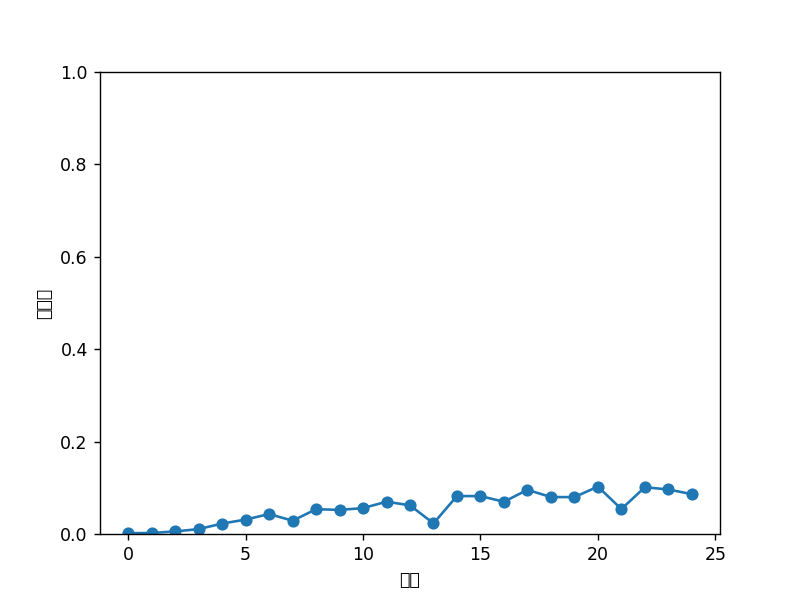

In [42]:
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
# from seq2seq import Seq2seq
# from peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

### reverse

In [ ]:
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
# from seq2seq import Seq2seq
# from peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

<IPython.core.display.Javascript object>


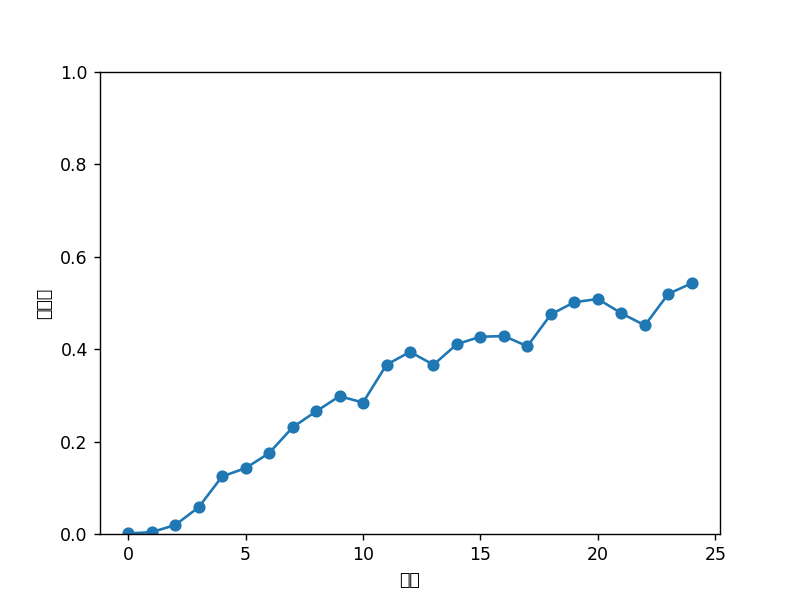

In [45]:
# 그래프 그리기
plt.figure()
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

### Peeky

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 3[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 4[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 5[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 6[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 6[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 7[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 8[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 9[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 10[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 11[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 11[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 12[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 13[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 14[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+84 
T 666 
X 102 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1023
---
Q 600+257
T 857 
X 1023
---
Q 761+292
T 1053
X 1023
---
Q 830+597
T 1427
X 1111
---
Q 

| 에폭 8 |  반복 341 / 351 | 시간 15[s] | 손실 0.34
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
X 657 
---
Q 8+155  
T 163 
X 155 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
X 1438
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 65.040%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.32
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.31
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 0.31
| 에폭 9 |  반복 61 / 351 | 시간 2[s] | 손실 0.31
| 에폭 9 |  반복 81 / 351 | 시간 3[s] | 손실 0.29
| 에폭 9 |  반복 101 / 351 | 시간 4[s] | 손실 0.29
| 에폭 9 |  반복 121 / 351 | 시간 5[s] | 손실 0.29
| 에폭 9 |  반복 141 / 351 | 시간 6[s] | 손실 0.27
| 에폭 9 |  반복 161 / 351 | 시간 6[s] | 손실 0.27
| 에폭 9 |  반복 181 / 351 | 시간 7[s] | 손실 0.26
| 에폭 9 |  반복 201 / 351 | 시간 8[s] | 손실 0.25
| 에폭 9 |  반복 221 / 351 | 시간 9[s] | 손실 0.25
| 에폭 9 |  반복 241 / 351 | 시간 10[s] | 손실 0.24
| 에폭 9 |  반복 261 / 351 | 시간 11[s] | 손실 0.24
| 에폭 9 |  반복 281 / 351 | 시간 12[s] | 손실 0.23
| 에폭 9 |  반복 301 / 

| 에폭 16 |  반복 141 / 351 | 시간 6[s] | 손실 0.04
| 에폭 16 |  반복 161 / 351 | 시간 6[s] | 손실 0.03
| 에폭 16 |  반복 181 / 351 | 시간 7[s] | 손실 0.04
| 에폭 16 |  반복 201 / 351 | 시간 8[s] | 손실 0.03
| 에폭 16 |  반복 221 / 351 | 시간 9[s] | 손실 0.03
| 에폭 16 |  반복 241 / 351 | 시간 10[s] | 손실 0.03
| 에폭 16 |  반복 261 / 351 | 시간 11[s] | 손실 0.03
| 에폭 16 |  반복 281 / 351 | 시간 12[s] | 손실 0.03
| 에폭 16 |  반복 301 / 351 | 시간 12[s] | 손실 0.03
| 에폭 16 |  반복 321 / 351 | 시간 13[s] | 손실 0.03
| 에폭 16 |  반복 341 / 351 | 시간 14[s] | 손실 0.04
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 97.180%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.03
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.03
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.03
| 에폭 17 |  반복 61 / 351 | 시간 2[s] | 손실 0.03
| 에폭 17 |  반복 81 / 351 | 시간 3[s] | 손실 0.03
|

검증 정확도 98.460%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.01
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.01
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.01
| 에폭 24 |  반복 61 / 351 | 시간 2[s] | 손실 0.01
| 에폭 24 |  반복 81 / 351 | 시간 3[s] | 손실 0.02
| 에폭 24 |  반복 101 / 351 | 시간 4[s] | 손실 0.01
| 에폭 24 |  반복 121 / 351 | 시간 5[s] | 손실 0.02
| 에폭 24 |  반복 141 / 351 | 시간 6[s] | 손실 0.04
| 에폭 24 |  반복 161 / 351 | 시간 6[s] | 손실 0.05
| 에폭 24 |  반복 181 / 351 | 시간 7[s] | 손실 0.06
| 에폭 24 |  반복 201 / 351 | 시간 8[s] | 손실 0.05
| 에폭 24 |  반복 221 / 351 | 시간 9[s] | 손실 0.03
| 에폭 24 |  반복 241 / 351 | 시간 10[s] | 손실 0.03
| 에폭 24 |  반복 261 / 351 | 시간 11[s] | 손실 0.04
| 에폭 24 |  반복 281 / 351 | 시간 11[s] | 손실 0.03
| 에폭 24 |  반복 301 / 351 | 시간 12[s] | 손실 0.03
| 에폭 24 |  반복 321 / 351 | 시간 13[s] | 손실 0.03
| 에폭 24 |  반복 341 / 351 | 시간 14[s] | 손실 0.03
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
-

<IPython.core.display.Javascript object>


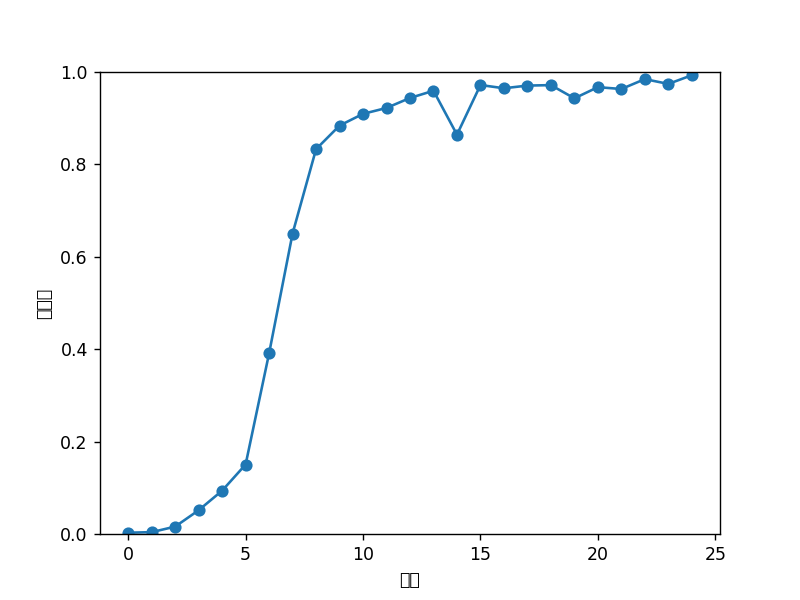

In [47]:
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
# from seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
# model = Seq2seq(vocab_size, wordvec_size, hideen_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
plt.figure()
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()